# 2. Pre-processing & post-processing

# Loading data


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


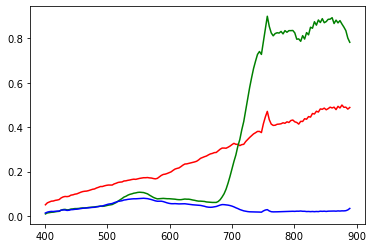

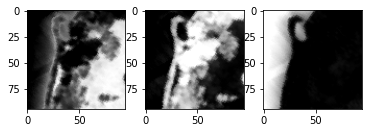

In [2]:
%pylab inline
from pysptools import abundance_maps
import numpy
import pandas as pd

import random
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

figure(1)
plot(wavelength, spectra[0], color='r')
plot(wavelength, spectra[1], color='g')
plot(wavelength, spectra[2], color='b')
plt.show()
figure(2)
subplot(1,3,1)
imshow(a_map[:,:,0],cmap=cm.gray)
subplot(1,3,2)
imshow(a_map[:,:,1],cmap=cm.gray)
subplot(1,3,3)
imshow(a_map[:,:,2],cmap=cm.gray)

# Acceleration algorithm 

In [3]:
c = sqrt(mean(hypercube**2))
hypercube = hypercube/c


l = 0.2
T = 2
U = 1


def sobel(img, threshold):
    '''
    edge detection based on sobel
    threshold (0,1)
    '''
    G_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    G_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    for i in range(0, rows - 2):
        for j in range(0, columns - 2):
            v = sum(sum(G_x * img[i:i+3, j:j+3]))  # vertical
            h = sum(sum(G_y * img[i:i+3, j:j+3]))  # horizon
            mag[i+1, j+1] = np.sqrt((v ** 2) + (h ** 2))
            
    for p in range(0, rows):
        for q in range(0, columns):
            if mag[p, q] < threshold:
                mag[p, q] = 1
    return mag

sober_img = np.zeros(hypercube.shape)

for i in range(hypercube.shape[2]):
    sober_img[:,:,i] = sobel(hypercube[:,:,i], l)
    
    
def tiles (img, t, u):
    '''
    t = tile_size
    u: percentage_of_edge_pixels
    '''
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    sub_area = np.zeros((t,t))      
    for p in range(0, rows):
        for q in range(0, columns):
            sub_area = img[p:p+t,q:q+t]
            area_sum = sum(sub_area)
            if area_sum > t*t*u:
                mag[p, q] = 1
    return mag

tiles_img = np.zeros(hypercube.shape)

for i in range(hypercube.shape[2]):
    tiles_img[:,:,i] = tiles(sober_img[:,:,i],T,U)

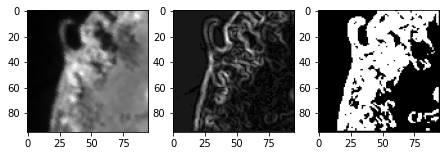

In [4]:
plt.figure(figsize=(10,10))

subplot(3,4,1)
imshow(hypercube[:,:,150],cmap=cm.gray)
subplot(3,4,2)
imshow(sober_img[:,:,150],cmap=cm.gray)
subplot(3,4,3)
imshow(tiles_img[:,:,150],cmap=cm.gray)

# Denoising using cv2 (operate on a_map, post_processing)

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def denoising_cv (hypercube,abundance_map, endmembers):
    N,M,P = abundance_map.shape
    _,_,K = hypercube.shape
    images = zeros((N,M,P))
    
    for i in range(P):
        predicted_NNLS = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,K)), spectra) # (N*M x P)
        images[:,:,i] = (255*(predicted_NNLS[:,i]/max(predicted_NNLS[:,i]))).reshape(N,M)
        image_gray = images[:,:,i].reshape(N,M)
        image_gray = np.uint8(image_gray)
        images_clean = cv2.fastNlMeansDenoising(image_gray)
        images[:,:,i] = images_clean/255
    
    return images

In [ ]:
images = denoising_cv (hypercube,a_map, spectra)

# Hypercube Noise Reduction (pre_processing)

In [ ]:
from scipy.signal import lfilter

def hypercube_noise_reduction(hypercube,smoother_factor_n = 15.,smoother_factor_a = 1.):
    N,M,K = hypercube.shape
    P,_ = endmembers.shape
    
    
    hyper_s = hypercube.reshape(N*M,K)
    n = smoother_factor_n 
    b = [1.0 / n] * n
    a = smoother_factor_a
    
    for i in range (N*M):
        y = hyper_s[i,:]
        yy = lfilter(b,a,y)
        hyper_s[i,:] = yy

    
    hyper_s = hyper_s.reshape((N,M,K))
    
    
    return hyper_s

In [ ]:
hyper_SS = hypercube_noise_reduction(hypercube,smoother_factor_n = 5, smoother_factor_a = 1)

# Neural Network_Nosie_reduction

In [6]:
def create_hypercube(a_map, spectra):
 
    '''
    Generate a hypercube.
    
    Inputs:
        a_map (N*M, L)
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.        
    
    N represents N*M!
    
    Output:
        hypercube (N*M, Q)
    '''

    N,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,i],spectra[i]).reshape((N,Q))
    
    return hypercube
def pre_processing(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array,predicted_a_map
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # generate hypercube by predicted abundance map
    x = create_hypercube(predicted, endmembers)
    y_reshape = abundance_map.reshape((N*M,len(endmember_sig)))
    y = create_hypercube(y_reshape, endmembers)
    
    # Take rms.
    acc = x - y
    accuracy = sqrt(mean(acc**2))


    return accuracy, x, y,predicted,y_reshape

In [7]:
center_wavelengths = [528., 684., 760.]
bandwidths = [20,20,20]

In [8]:
acc, X_predicted, X_groud_truth,Y_predicted, Y_groud_truth = pre_processing(hypercube, a_map, spectra,wavelength, center_wavelengths, bandwidths, return_predicted=False)

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras import layers
from keras import models

In [10]:
X_predicted_half,X2_predicted_half,Y_predicted_half,Y2_predicted_half = train_test_split(X_predicted, Y_predicted, test_size=0.5)

In [11]:
x_train = np.vstack((X_predicted_half,X_groud_truth))
y_train = np.vstack((Y_predicted_half,Y_groud_truth))
x_test = X2_predicted_half
y_test = Y2_predicted_half

In [12]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    
    tf.keras.layers.Dense(3,'softmax')
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [13]:
model = get_compiled_model()

In [14]:
history = model.fit(x_train,y_train, epochs=30)

Epoch 1/30
424/424 [==============================] - 0s 781us/step - loss: 0.4305 - accuracy: 0.9330
Epoch 2/30
424/424 [==============================] - 0s 801us/step - loss: 0.4183 - accuracy: 0.9601
Epoch 3/30
424/424 [==============================] - 0s 836us/step - loss: 0.4177 - accuracy: 0.9671
Epoch 4/30
424/424 [==============================] - 0s 782us/step - loss: 0.4170 - accuracy: 0.9672
Epoch 5/30
424/424 [==============================] - 0s 772us/step - loss: 0.4168 - accuracy: 0.9724
Epoch 6/30
424/424 [==============================] - 0s 814us/step - loss: 0.4173 - accuracy: 0.9679
Epoch 7/30
424/424 [==============================] - 0s 778us/step - loss: 0.4165 - accuracy: 0.9702
Epoch 8/30
424/424 [==============================] - 0s 810us/step - loss: 0.4165 - accuracy: 0.9693
Epoch 9/30
424/424 [==============================] - 0s 762us/step - loss: 0.4149 - accuracy: 0.9808
Epoch 10/30
424/424 [==============================] - 0s 784us/step - loss: 0.414

In [15]:
loss,acc = model.evaluate(x_test,y_test, verbose=1)

142/142 [==============================] - 0s 502us/step - loss: -0.0169 - accuracy: 0.9812
